In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import torch as t
import torch.nn as nn
import pytorch_lightning as pl
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [3]:
from src.data.dataset import BirdMelTrainDataset, EBIRD_CODE_TO_INDEX, INDEX_TO_EBIRD_CODE

In [2]:
df = pd.read_csv('../data/raw/birdsong-recognition/train.csv')
df = df[df['filename'] != 'XC313679.mp3']
df = df[df['duration'] < 60]
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['ebird_code'])
train_dataset = BirdMelTrainDataset(
    train_df,
    '../data/processed/mel_specs_train/',
    True,
    Compose([
        RandomTimeResize(resize_mode='bilinear'),
        TimeMasking(40),
        FrequencyMasking(16),
    ])
)

test_dataset = BirdMelTrainDataset(
    test_df,
    '../data/processed/mel_specs_train/',
    True
)

NameError: name 'BirdMelTrainDataset' is not defined

In [5]:
min([t.min(x['mel_spec']) for x in train_dataset])

tensor(0.)

In [6]:
max_log = max([t.log(t.max(x['mel_spec']) + 0.0001) for x in train_dataset])

In [7]:
min_log = min([t.log(t.min(x['mel_spec']) + 0.0001) for x in train_dataset])

In [20]:
# Pad sequences to the same length and to closest round 100 mel frames ~ 1.15 sec
def collate(batch):
    # print('Hmm')
    batch_size = len(batch)
    
    lengths = [x['mel_spec'].size(1) for x in batch]
    max_length = max(lengths)
    
    n_frames = 100
    k = (max_length // n_frames) + 1
    padded_length = k * n_frames
    
    n_mels = batch[0]['mel_spec'].size(0)
    
    batched_mels = t.zeros(batch_size, n_mels, padded_length)
    
    segment_lengths = [(length // n_frames) + 1 for length in lengths]
    with t.no_grad():
        for i, item in enumerate(batch):
            mel_spec = t.log(item['mel_spec'] + 0.0001)
            mel_spec = (mel_spec - min_log) / (min_log - max_log)
            batched_mels[i, :, :mel_spec.size(1)] = mel_spec
    
    primary_labels = [x['primary_label'] for x in batch]
    secondary_labels = [x['secondary_labels'] for x in batch]
    durations = [x['duration'] for x in batch]
    
    ebird_encoded = t.cat([x['ebird_encoded'].view(1, -1) for x in batch], dim=0)
    ebird_codes = [x['ebird_code'] for x in batch]
    
    return {
        'mel_specs': batched_mels,
        'original_lengths': lengths,
        'ebird_encoded': ebird_encoded,
        'ebird_codes': ebird_codes,
        'primary_labels': primary_labels,
        'secondary_labels': secondary_labels,
        'segment_lengths': segment_lengths,
        'durations': durations,
    }

In [21]:
dataloader = t.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=collate)

In [10]:
t.max(t.log(train_dataset[0]['mel_spec']))

tensor(8.7729)

In [11]:
t.min(t.log(train_dataset[0]['mel_spec'] + 0.0001))

tensor(-9.2103)

In [12]:
for batch in tqdm(dataloader):
    pass

100%|██████████| 758/758 [00:12<00:00, 60.38it/s]


In [41]:
class ExperimentModel(pl.LightningModule):
    def __init__(self, n_classes, n_mels, segment_size, lr=0.001):
        super().__init__()
        self.conv_1 = t.nn.Conv2d(1, 48, (5, 5))
        self.maxpool_1 = t.nn.MaxPool2d((2, 2))
        self.conv_2 = t.nn.Conv2d(48, 48, (5, 5))
        self.maxpool_2 = t.nn.MaxPool2d((2, 2))
        self.conv_3 = t.nn.Conv2d(48, 48, (3, 3))
        self.maxpool_3 = t.nn.MaxPool2d((2, 2))
        self.conv_4 = t.nn.Conv2d(48, 48, (3, 3))
        self.dropout = t.nn.Dropout(0.5)
        self.linear_1 = t.nn.Linear(8448, n_classes)
        
        self.n_mels = n_mels
        self.segment_size = segment_size
        self.n_classes = n_classes
        self.lr = lr
        
    def forward(self, batch):
        batch_size = len(batch['mel_specs'])
        n_segments = max(batch['segment_lengths'])
        mel_specs = batch['mel_specs']
        mel_specs = mel_specs.view(n_segments * batch_size, 1, self.n_mels, -1)
        
#         print('Mel specs shape: ', mel_specs.shape)
        
        
#         print(mel_specs.shape)
        
        x = self.conv_1(mel_specs)
        x = self.maxpool_1(x)
        x = t.relu(x)
        
#         print(x.shape)
        
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        x = t.relu(x)
        
#         print(x.shape)
        
        x = self.conv_3(x)
        x = self.maxpool_3(x)
        x = t.relu(x)
        
        x = self.conv_4(x)
        
#         print(x.shape)
        
        
        x = x.view(batch_size, n_segments, -1)
        x = self.dropout(x)
        
#         print('X shape before pooling: ', x.shape)
        
        # print(x.shape)
        x1 = t.mean(x, dim=1)
        x2, _ = t.max(x, dim=1)

        x = t.cat((x1, x2), dim=-1)
        
#         print('X shape before linear: ', x.shape)
        
        x = self.linear_1(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        prediction = self(batch)
        loss = t.nn.functional.binary_cross_entropy_with_logits(
            prediction,
            batch['ebird_encoded']
        )
        tensorboard_logs = {'train/loss': loss.item()}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        prediction = self(batch)
        loss = t.nn.functional.binary_cross_entropy_with_logits(
            prediction,
            batch['ebird_encoded']
        )
        predicted_ranking = t.argsort(prediction, dim=1, descending=True)
        expected_indices = [EBIRD_CODE_TO_INDEX[x] for x in batch['ebird_codes']]
        
        top_1 = []
        top_3 = []
        top_5 = []
        
        for expected_index, ranking in zip(expected_indices, predicted_ranking):
            if expected_index in ranking[:1]:
                top_1.append(1)
            else:
                top_1.append(0)
                
            if expected_index in ranking[:3]:
                top_3.append(1)
            else:
                top_3.append(0)
                
            if expected_index in ranking[:5]:
                top_5.append(1)
            else:
                top_5.append(0)
        return {'val_loss': loss, 'top_1': top_1, 'top_3': top_3, 'top_5': top_5}
    
    def validation_epoch_end(self, outputs):
        val_loss_mean = t.stack([x['val_loss'] for x in outputs]).mean()
        top_1 = np.mean(list(chain(*[x['top_1'] for x in outputs])))
        top_3 = np.mean(list(chain(*[x['top_3'] for x in outputs])))
        top_5 = np.mean(list(chain(*[x['top_5'] for x in outputs])))
        tensorboard_logs = {'val/loss': val_loss_mean, 'val/top_1': top_1, 'val/top_3': top_3, 'val/top_5': top_5}
        return {'val_loss': val_loss_mean, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        return t.optim.Adam(self.parameters(), lr=self.lr)
        
        

In [42]:
train_dataloader = t.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate,
    num_workers=8,
)

In [43]:
test_dataloader = t.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate,
    num_workers=8,
)

In [44]:
model = ExperimentModel(264, 128, 100)

In [45]:
trainer = pl.Trainer(gpus=1, accumulate_grad_batches=4, row_log_interval=64, auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [46]:
trainer.fit(model, train_dataloader, test_dataloader)


  | Name      | Type      | Params
----------------------------------------
0 | conv_1    | Conv2d    | 1 K   
1 | maxpool_1 | MaxPool2d | 0     
2 | conv_2    | Conv2d    | 57 K  
3 | maxpool_2 | MaxPool2d | 0     
4 | conv_3    | Conv2d    | 20 K  
5 | maxpool_3 | MaxPool2d | 0     
6 | conv_4    | Conv2d    | 20 K  
7 | dropout   | Dropout   | 0     
8 | linear_1  | Linear    | 2 M   


LR finder stopped early due to diverging loss.
Learning rate set to 0.0003019951720402019

  | Name      | Type      | Params
----------------------------------------
0 | conv_1    | Conv2d    | 1 K   
1 | maxpool_1 | MaxPool2d | 0     
2 | conv_2    | Conv2d    | 57 K  
3 | maxpool_2 | MaxPool2d | 0     
4 | conv_3    | Conv2d    | 20 K  
5 | maxpool_3 | MaxPool2d | 0     
6 | conv_4    | Conv2d    | 20 K  
7 | dropout   | Dropout   | 0     
8 | linear_1  | Linear    | 2 M   


/mnt/datadisk/cornell-birdcall-identification/env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [96]:
model.

SyntaxError: invalid syntax (<ipython-input-96-e5c9403477cf>, line 1)

In [ ]:
model.to('cpu')

In [16]:
ExperimentModel.load_from_checkpoint('./lightning_logs/version_44/checkpoints/epoch=17.ckpt')

TypeError: __init__() missing 2 required positional arguments: 'n_mels' and 'segment_size'

In [44]:
model = model.to('cpu')

In [45]:
model = model.eval()

In [47]:
all_preds = []
predicted_indices = []
expected_indices = []
with t.no_grad():
    for sample in tqdm(t.utils.data.DataLoader(test_dataset, collate_fn=collate)):
        preds = model(sample)
        all_preds.append(preds)
        expected_index = t.argmax(sample['ebird_encoded']).item()
        predicted_index = t.argmax(preds).item()
        predicted_indices.append(predicted_index)
        expected_indices.append(expected_index)
        # print('Expected: ', INDEX_TO_EBIRD_CODE[expected_index])
        # print('Predicted: ', INDEX_TO_EBIRD_CODE[predicted_index])

100%|██████████| 1390/1390 [00:06<00:00, 200.25it/s]


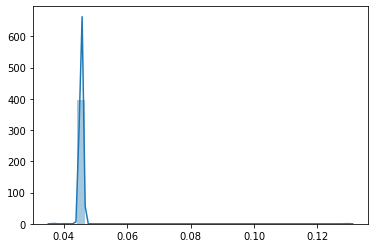

In [54]:
sb.distplot(([t.sigmoid(t.max(x)) for x in all_preds]))

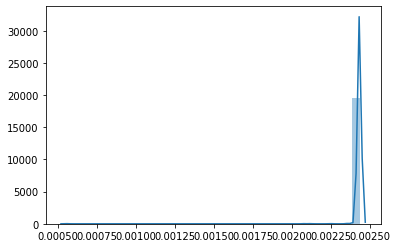

In [55]:
sb.distplot(([t.sigmoid(t.mean(x)) for x in all_preds]))

In [62]:
mean_preds_per_class = t.mean(t.cat([x.unsqueeze(0) for x in all_preds]), dim=0)

<BarContainer object of 264 artists>

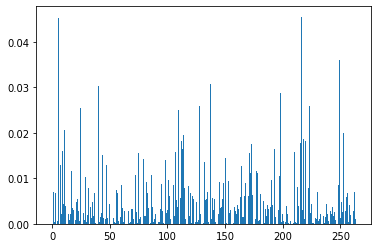

In [73]:
plt.bar(list(range(mean_preds_per_class.size(1))), t.sigmoid(mean_preds_per_class[0]).tolist())

In [ ]:
predicted_indices

In [21]:
from sklearn.metrics import accuracy_score

In [85]:
accuracy_score(predicted_indices, expected_indices)

0.0028776978417266188

In [75]:
a = list(zip([x == y for x, y in zip(predicted_indices, expected_indices)], all_preds))

In [77]:
a = [x for x in a if x[0]]

In [84]:
len(a)

4

In [82]:
for x in a:
    print(t.sigmoid(t.max(x[1])))

tensor(0.0454)
tensor(0.0455)
tensor(0.0438)
tensor(0.0455)


In [33]:
sum(results)

tensor(116)